# Sentiment Analysis in Arabic tweets 


# Table of Contents

- [Part 1: Import Libraries](##part-1-import-libraries)
- [Part 2: Data Preparation](#part-2-data-preparation)
- [Part 3: Exploratory Data Analysis (EDA)](#part-3-exploratory-data-analysis-eda)
- [Part 4: Build Model](#part-4-build-model)


## Part 1:Import Libraries

In [93]:
# Import essential libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib.cm as cm
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
import string
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pyarabic.araby as araby
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
# read the data
df_test_neg=pd.read_csv('test_Arabic_tweets_negative_20190413.tsv', sep='\t',names=['Sentiment Label', 'Arabic tweet'])
df_test_pos=pd.read_csv('test_Arabic_tweets_positive_20190413.tsv', sep='\t',names=['Sentiment Label', 'Arabic tweet'])
df_train_neg=pd.read_csv('train_Arabic_tweets_negative_20190413.tsv', sep='\t',names=['Sentiment Label', 'Arabic tweet'])
df_train_pos=pd.read_csv('train_Arabic_tweets_positive_20190413.tsv', sep='\t',names=['Sentiment Label', 'Arabic tweet'])

In [94]:
#view first 5 rows
df_test_neg.head()

,Sentiment Label,Arabic tweet
0,neg,حتى الايتونز خربتوه مو صاحين انتو؟؟ 😭
1,neg,واحد تبع النظام السوري يقول أن المخابرات السور...
2,neg,الى متى التعامل السئ للخادمات وعدم احترامهم وك...
3,neg,رايح جاي ي طحلبي 🐸 #الهلال_الاهلي
4,neg,تتمغط ومعها سداع 😫


# Part 2: Data Preparation

In [95]:
#checking the number of rows
print(len(df_test_neg))
print(len(df_test_pos))
print(len(df_train_neg))
print(len(df_train_pos))

5768
5752
22514
22761


In [96]:
# Check for any missing (null) values in each dataset
print("Null values in df_test_neg:")
print(df_test_neg.isnull().sum())
print("\nNull values in df_test_pos:")
print(df_test_pos.isnull().sum())
print("\nNull values in df_train_neg:")
print(df_train_neg.isnull().sum())
print("\nNull values in df_train_pos:")
print(df_train_pos.isnull().sum())


Null values in df_test_neg:
Sentiment Label    0
Arabic tweet       0
dtype: int64

Null values in df_test_pos:
Sentiment Label    0
Arabic tweet       0
dtype: int64

Null values in df_train_neg:
Sentiment Label    0
Arabic tweet       0
dtype: int64

Null values in df_train_pos:
Sentiment Label    0
Arabic tweet       0
dtype: int64


In [97]:
df_test_neg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5768 entries, 0 to 5767
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Sentiment Label  5768 non-null   object
 1   Arabic tweet     5768 non-null   object
dtypes: object(2)
memory usage: 90.3+ KB


In [98]:
df_test_pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5752 entries, 0 to 5751
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Sentiment Label  5752 non-null   object
 1   Arabic tweet     5752 non-null   object
dtypes: object(2)
memory usage: 90.0+ KB


In [99]:
df_train_neg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22514 entries, 0 to 22513
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Sentiment Label  22514 non-null  object
 1   Arabic tweet     22514 non-null  object
dtypes: object(2)
memory usage: 351.9+ KB


In [100]:
df_train_pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22761 entries, 0 to 22760
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Sentiment Label  22761 non-null  object
 1   Arabic tweet     22761 non-null  object
dtypes: object(2)
memory usage: 355.8+ KB


### Cleaning the Arabic Tweets

In [101]:
# Remove specific unwanted characters from the tweets
for letter in '#.][!XR':
    df_test_neg['Arabic tweet'] = df_test_neg['Arabic tweet'].astype(str).str.replace(letter,'')
    df_test_pos['Arabic tweet'] = df_test_pos['Arabic tweet'].astype(str).str.replace(letter,'')
    df_train_neg['Arabic tweet'] = df_train_neg['Arabic tweet'].astype(str).str.replace(letter,'')
    df_train_pos['Arabic tweet'] = df_train_pos['Arabic tweet'].astype(str).str.replace(letter,'')

In [102]:
df_test_pos.head()

,Sentiment Label,Arabic tweet
0,pos,الهلال_الاهلي فوز هلالي مهم الحمد لله 💙 زوران ...
1,pos,صباحك خيرات ومسرات 🌸
2,pos,تأمل قال الله ﷻ :- _*​﴿بواد غير ذي زرع ﴾*_ 💫💫 ...
3,pos,😂😂 يا جدعان الرجاله اللي فوق ال دول خطر ع تويت...
4,pos,رساله صباحيه : 💛 اللهم اسألك التوفيق في جميع ا...


In [103]:
#Define punctuation lists 
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations
# Function to remove all punctuation from text
def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [104]:
#normalize_arabic_text
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text

In [105]:
# remove_repeating_char
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [106]:
# strip_diacritics
df_test_neg['Arabic tweet'] = df_test_neg['Arabic tweet'].apply(araby.strip_diacritics)
df_test_pos['Arabic tweet'] = df_test_pos['Arabic tweet'].apply(araby.strip_diacritics)
df_train_neg['Arabic tweet'] = df_train_neg['Arabic tweet'].apply(araby.strip_diacritics)
df_train_pos['Arabic tweet'] = df_train_pos['Arabic tweet'].apply(araby.strip_diacritics)

In [107]:
df_test_neg.head()

,Sentiment Label,Arabic tweet
0,neg,حتى الايتونز خربتوه مو صاحين انتو؟؟ 😭
1,neg,واحد تبع النظام السوري يقول أن المخابرات السور...
2,neg,الى متى التعامل السئ للخادمات وعدم احترامهم وك...
3,neg,رايح جاي ي طحلبي 🐸 الهلال_الاهلي
4,neg,تتمغط ومعها سداع 😫


In [108]:
#Remove and replace mentions, hashtags, links and special characters
def processPost(text): 

    text = re.sub('@[^\s]+', ' ', text)
    
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)
    
    text = re.sub(r'#([^\s]+)', r'\1', text)

    text= remove_punctuations(text)
    
    text=remove_repeating_char(text)
    
    return text

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Mua\AppData\Local\Temp\ipykernel_21864\2842269798.py:4: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('@[^\s]+', ' ', text)
C:\Users\Mua\AppData\Local\Temp\ipykernel_21864\2842269798.py:6: SyntaxWarning: invalid escape sequence '\.'
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)


In [109]:
# apply used to call the method processpost
df_test_neg["Arabic tweet"] = df_test_neg['Arabic tweet'].apply(lambda x: processPost(x)) 
df_test_pos["Arabic tweet"] = df_test_pos['Arabic tweet'].apply(lambda x: processPost(x)) 
df_train_neg["Arabic tweet"] = df_train_neg['Arabic tweet'].apply(lambda x: processPost(x)) 
df_train_pos["Arabic tweet"] = df_train_pos['Arabic tweet'].apply(lambda x: processPost(x))

In [110]:
# Initialize a RegexpTokenizer to capture word characters
tokenizer = RegexpTokenizer(r'\w+')
# Apply tokenization on the "Arabic tweet" column for each dataset
df_test_neg['tokens'] = df_test_neg["Arabic tweet"].apply(tokenizer.tokenize)
df_test_pos['tokens'] = df_test_pos["Arabic tweet"].apply(tokenizer.tokenize)
df_train_neg['tokens'] = df_train_neg["Arabic tweet"].apply(tokenizer.tokenize)
df_train_pos['tokens'] = df_train_pos["Arabic tweet"].apply(tokenizer.tokenize)


In [111]:
# check new column tokens
df_test_neg.head()

,Sentiment Label,Arabic tweet,tokens
0,neg,حتى الايتونز خربتوه مو صاحين انتو 😭,"[حتى, الايتونز, خربتوه, مو, صاحين, انتو]"
1,neg,واحد تبع النظام السوري يقول أن المخابرات السور...,"[واحد, تبع, النظام, السوري, يقول, أن, المخابرا..."
2,neg,الى متى التعامل السئ لخادمات وعدم احترامهم وكأ...,"[الى, متى, التعامل, السئ, لخادمات, وعدم, احترا..."
3,neg,رايح جاي ي طحلبي 🐸 الهلالالاهلي,"[رايح, جاي, ي, طحلبي, الهلالالاهلي]"
4,neg,تمغط ومعها سداع 😫,"[تمغط, ومعها, سداع]"


In [112]:
# list arabic stopwords
stopwords_list = stopwords.words('arabic')
# Display the stopwords list and the count of stopwords
print(stopwords_list)
print("Number of stopwords:", len(stopwords_list))

['إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر', 'ألا', 'إلا', 'التي', 'الذي', 'الذين', 'اللاتي', 'اللائي', 'اللتان', 'اللتيا', 'اللتين', 'اللذان', 'اللذين', 'اللواتي', 'إلى', 'إليك', 'إليكم', 'إليكما', 'إليكن', 'أم', 'أما', 'أما', 'إما', 'أن', 'إن', 'إنا', 'أنا', 'أنت', 'أنتم', 'أنتما', 'أنتن', 'إنما', 'إنه', 'أنى', 'أنى', 'آه', 'آها', 'أو', 'أولاء', 'أولئك', 'أوه', 'آي', 'أي', 'أيها', 'إي', 'أين', 'أين', 'أينما', 'إيه', 'بخ', 'بس', 'بعد', 'بعض', 'بك', 'بكم', 'بكم', 'بكما', 'بكن', 'بل', 'بلى', 'بما', 'بماذا', 'بمن', 'بنا', 'به', 'بها', 'بهم', 'بهما', 'بهن', 'بي', 'بين', 'بيد', 'تلك', 'تلكم', 'تلكما', 'ته', 'تي', 'تين', 'تينك', 'ثم', 'ثمة', 'حاشا', 'حبذا', 'حتى', 'حيث', 'حيثما', 'حين', 'خلا', 'دون', 'ذا', 'ذات', 'ذاك', 'ذان', 'ذانك', 'ذلك', 'ذلكم', 'ذلكما', 'ذلكن', 'ذه', 'ذو', 'ذوا', 'ذواتا', 'ذواتي', 'ذي', 'ذين', 'ذينك', 'ريث', 'سوف', 'سوى', 'شتان', 'عدا', 'عسى', 'عل', 'على', 'عليك', 'عليه', 'عما', 'عن', 'عند', 'غير', 'فإذا', 'فإن', 'فلا', 'فمن', 'في', 'فيم', 'فيما', 'فيه', 'فيها', '

# Part 3: Exploratory data analysis (EDA)

In [113]:
# make merged dataframe to make EDA
df_mearge_pos=pd.concat([df_train_pos,df_test_pos])
df_mearge_neg=pd.concat([df_train_neg,df_test_neg])

In [114]:
# check merged dataframe
df_mearge_pos

,Sentiment Label,Arabic tweet,tokens
0,pos,نحن الذين يتحول كل ما نود أن نقوله إلى دعاء له...,"[نحن, الذين, يتحول, كل, ما, نود, أن, نقوله, إل..."
1,pos,وفي النهاية لن يبقى معك آحدإلا من رأى الجمال ف...,"[وفي, النهاية, لن, يبقى, معك, آحدإلا, من, رأى,..."
2,pos,من الخير نفسه 💛,"[من, الخير, نفسه]"
3,pos,زلزلالملعبنصرنابيلعب كن عالي الهمه ولا ترضى بغ...,"[زلزلالملعبنصرنابيلعب, كن, عالي, الهمه, ولا, ت..."
4,pos,الشيء الوحيد الذي وصلوا فيه لعالمية هو المسيار...,"[الشيء, الوحيد, الذي, وصلوا, فيه, لعالمية, هو,..."
...,...,...,...
5747,pos,ربي اغفر لي و لوالدي و لأحبتي و لمؤمنين و المؤ...,"[ربي, اغفر, لي, و, لوالدي, و, لأحبتي, و, لمؤمن..."
5748,pos,ربي يسعدنا وياكم 💛,"[ربي, يسعدنا, وياكم]"
5749,pos,يتحدثون عن اخلاق حسين ونجوم فرقهم نهاياتهم الر...,"[يتحدثون, عن, اخلاق, حسين, ونجوم, فرقهم, نهايا..."
5750,pos,صباحكم احتفالية لم تكتمل وصاحب الاحتفاليه ماكم...,"[صباحكم, احتفالية, لم, تكتمل, وصاحب, الاحتفالي..."


In [115]:
# check merged dataframe
df_mearge_neg

,Sentiment Label,Arabic tweet,tokens
0,neg,اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم...,"[اعترف, ان, بتس, كانو, شوي, شوي, يجيبو, راسي, ..."
1,neg,توقعت اذا جات داريا بشوفهم كاملين بس لي لحين ا...,"[توقعت, اذا, جات, داريا, بشوفهم, كاملين, بس, ل..."
2,neg,الاهليالهلال اكتب توقعك لنتيجة لقاء الهلال وال...,"[الاهليالهلال, اكتب, توقعك, لنتيجة, لقاء, الهل..."
3,neg,نعمة المضادات الحيوية تضع قطرة💧مضاد بنسلين على...,"[نعمة, المضادات, الحيوية, تضع, قطرة, مضاد, بنس..."
4,neg,الدودو جايه تكمل علي 💔,"[الدودو, جايه, تكمل, علي]"
...,...,...,...
5763,neg,النوم وانت مكسور ده احساس غبي الي هو مش قادر ت...,"[النوم, وانت, مكسور, ده, احساس, غبي, الي, هو, ..."
5764,neg,استشهادالامامكاظمالغيظ السلام على المعذب في قع...,"[استشهادالامامكاظمالغيظ, السلام, على, المعذب, ..."
5765,neg,انا كنت اكل الصحن بكبره 😐,"[انا, كنت, اكل, الصحن, بكبره]"
5766,neg,قولوا لي ايش تشوفوا مع ملاحظة التلطف لأنه المو...,"[قولوا, لي, ايش, تشوفوا, مع, ملاحظة, التلطف, ل..."


In [116]:
# see the most word frequancy in postive with number of frequancy
df_mearge_pos['tokens'].explode().value_counts()

tokens
من           6534
اله          5354
في           5164
على          4144
و            3618
             ... 
والخيالات       1
والتأملات       1
سكروز           1
بطايه           1
راسبين          1
Name: count, Length: 48503, dtype: int64

In [117]:
# see the most word frequancy in negtive with number of frequancy
df_mearge_neg['tokens'].explode().value_counts()

tokens
من             6468
في             4313
و              3363
اله            3101
ما             2601
               ... 
باعصابي           1
يجمد              1
كيفهالاغنية       1
شلحلو             1
ثاقل              1
Name: count, Length: 46936, dtype: int64

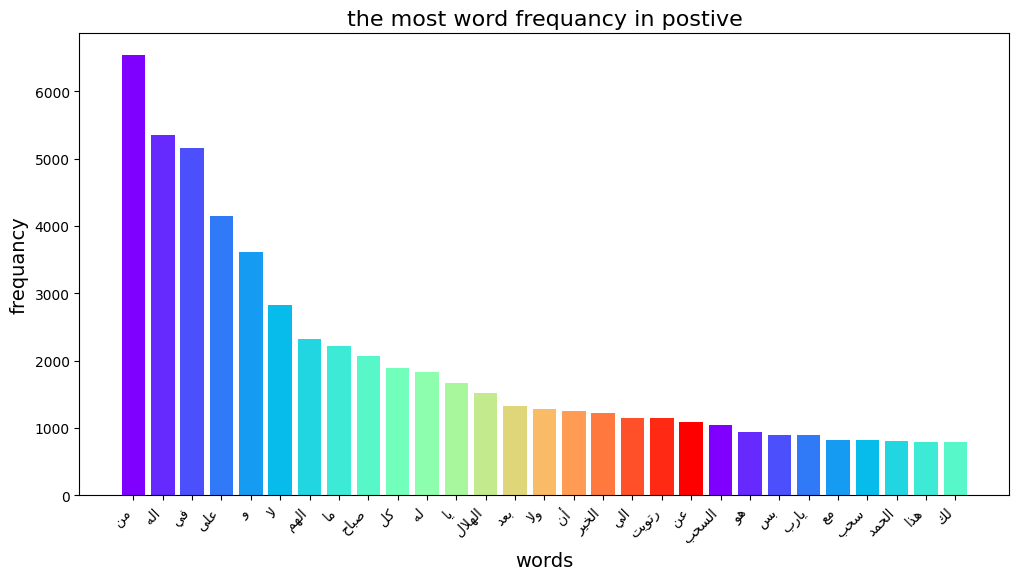

In [118]:
# get the most word frequancy in postive
token_counts = df_mearge_pos['tokens'].explode().value_counts().head(30)
token_counts = token_counts[~token_counts.index.isin(["pos"])]

# Reshape each token for proper Arabic rendering:
reshaped_tokens = [get_display(arabic_reshaper.reshape(token)) for token in token_counts.index]



# make color for bar chart
colors = cm.rainbow(np.linspace(0, 1, 20))

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(reshaped_tokens, token_counts.values, color=colors)

title_ar = get_display(arabic_reshaper.reshape("the most word frequancy in postive"))
xlabel_ar = get_display(arabic_reshaper.reshape("words"))
ylabel_ar = get_display(arabic_reshaper.reshape("frequancy"))

ax.set_title(title_ar, fontsize=16)
ax.set_xlabel(xlabel_ar, fontsize=14)
ax.set_ylabel(ylabel_ar, fontsize=14)

plt.xticks(rotation=45, ha='right')
plt.show()


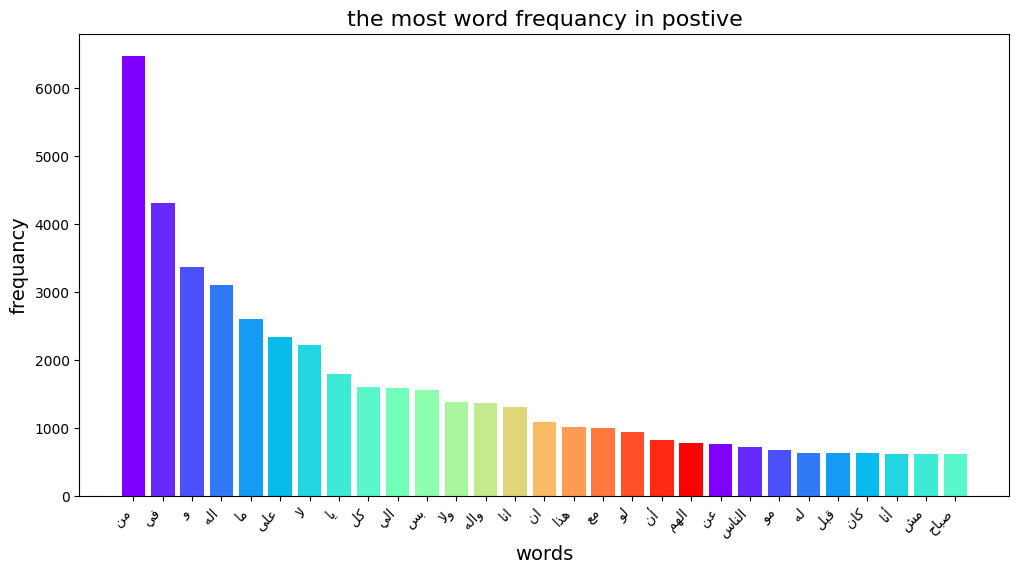

In [119]:
# get the most word frequancy in negtive
token_counts = df_mearge_neg['tokens'].explode().value_counts().head(30)
token_counts = token_counts[~token_counts.index.isin(["neg"])]

# Reshape each token for proper Arabic rendering:
reshaped_tokens = [get_display(arabic_reshaper.reshape(token)) for token in token_counts.index]
# make color for bar chart
colors = cm.rainbow(np.linspace(0, 1, 20))
# 
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(reshaped_tokens, token_counts.values, color=colors)

title_ar = get_display(arabic_reshaper.reshape("the most word frequancy in postive"))
xlabel_ar = get_display(arabic_reshaper.reshape("words"))
ylabel_ar = get_display(arabic_reshaper.reshape("frequancy"))

ax.set_title(title_ar, fontsize=16)
ax.set_xlabel(xlabel_ar, fontsize=14)
ax.set_ylabel(ylabel_ar, fontsize=14)

plt.xticks(rotation=45, ha='right')
plt.show()


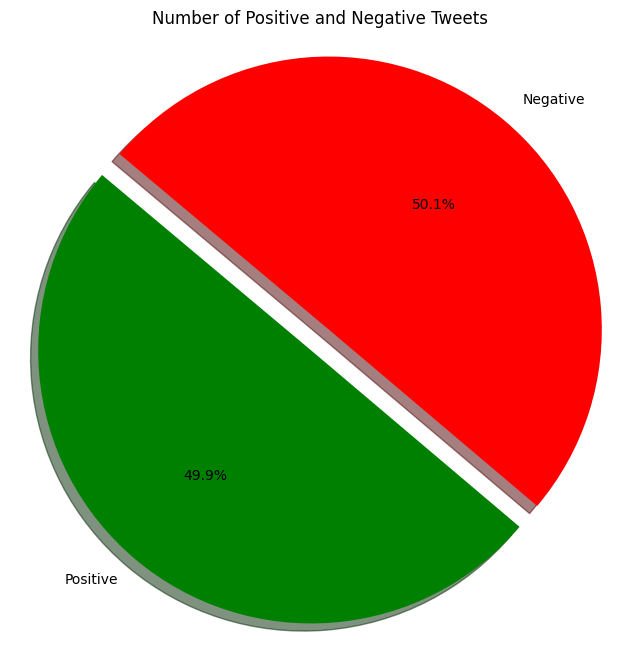

In [120]:
# Count the number of positive and negative tweets
pos_count = len(df_test_pos)
neg_count = len(df_test_neg)

# Labels and counts for the pie chart
labels = ['Positive', 'Negative']
sizes = [pos_count, neg_count]

colors = ['green', 'red']
explode = (0.1, 0) 

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.title('Number of Positive and Negative Tweets')
plt.axis('equal')
plt.show()


### Removing Stopwords and Analyzing Token Frequency Again



In [121]:
# removeing stop words
df_mearge_pos['tokens'] = df_mearge_pos['tokens'].apply(lambda x: [word for word in x if word not in stopwords_list])
df_mearge_neg['tokens'] = df_mearge_neg['tokens'].apply(lambda x: [word for word in x if word not in stopwords_list])

In [122]:
# see the most word frequancy in postive with number of frequancy
df_mearge_pos['tokens'].explode().value_counts()

tokens
اله         5354
الهم        2328
الهلال      1517
pos         1336
الخير       1220
            ... 
مشية           1
فرس            1
المؤمنات       1
المسلمات       1
فلرب           1
Name: count, Length: 48119, dtype: int64

In [123]:
# see the most word frequancy in negtive with number of frequancy
df_mearge_neg['tokens'].explode().value_counts()    

tokens
اله           3101
الي           1586
واله          1373
انا           1315
ان            1090
              ... 
إمكانك           1
شريكالحياه       1
السوشال          1
اتعمق            1
وانخذل           1
Name: count, Length: 46555, dtype: int64

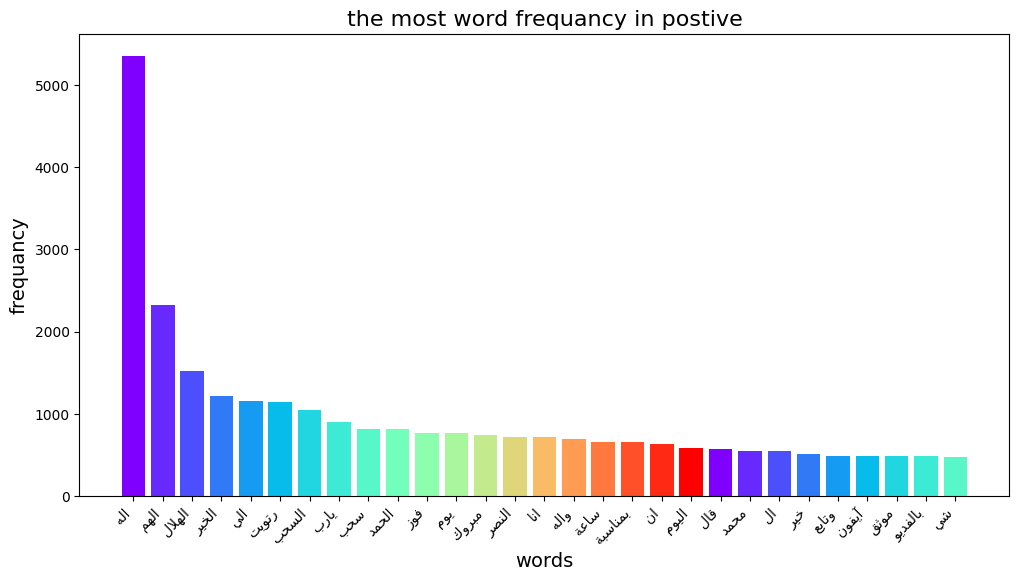

In [124]:
# get the most word frequancy in postive
token_counts = df_mearge_pos['tokens'].explode().value_counts().head(30)
token_counts = token_counts[~token_counts.index.isin(["pos"])]

# Reshape each token for proper Arabic rendering:
reshaped_tokens = [get_display(arabic_reshaper.reshape(token)) for token in token_counts.index]


# make color for bar chart
colors = cm.rainbow(np.linspace(0, 1, 20))
# 
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(reshaped_tokens, token_counts.values, color=colors)

title_ar = get_display(arabic_reshaper.reshape("the most word frequancy in postive"))
xlabel_ar = get_display(arabic_reshaper.reshape("words"))
ylabel_ar = get_display(arabic_reshaper.reshape("frequancy"))

ax.set_title(title_ar, fontsize=16)
ax.set_xlabel(xlabel_ar, fontsize=14)
ax.set_ylabel(ylabel_ar, fontsize=14)

plt.xticks(rotation=45, ha='right')
plt.show()


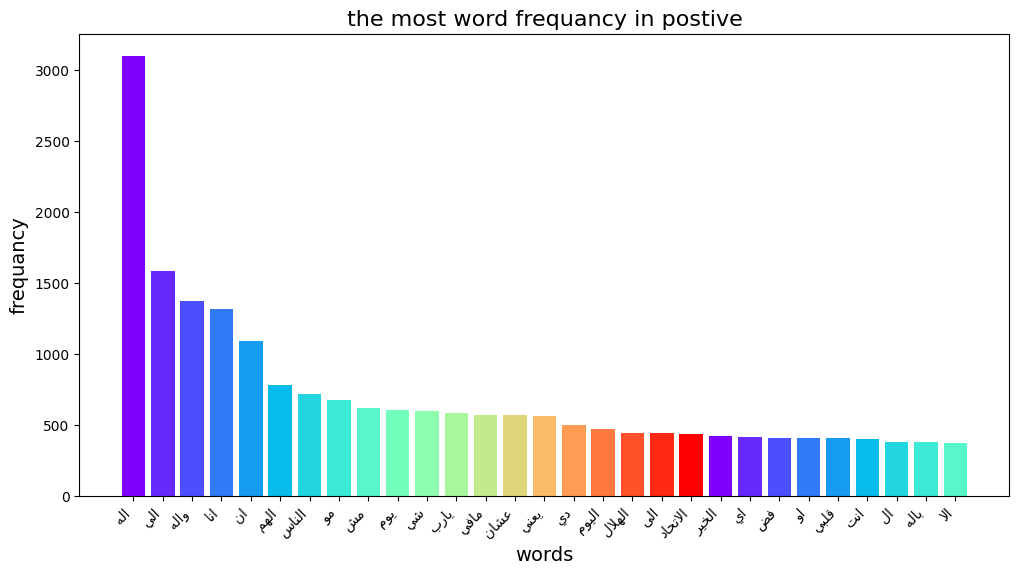

In [125]:
# get the most word frequancy in negtive
token_counts = df_mearge_neg['tokens'].explode().value_counts().head(30)
token_counts = token_counts[~token_counts.index.isin(["neg"])]

# Reshape each token for proper Arabic rendering:
reshaped_tokens = [get_display(arabic_reshaper.reshape(token)) for token in token_counts.index]

# make color for bar chart
colors = cm.rainbow(np.linspace(0, 1, 20))
# 
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(reshaped_tokens, token_counts.values, color=colors)

title_ar = get_display(arabic_reshaper.reshape("the most word frequancy in postive"))
xlabel_ar = get_display(arabic_reshaper.reshape("words"))
ylabel_ar = get_display(arabic_reshaper.reshape("frequancy"))

ax.set_title(title_ar, fontsize=16)
ax.set_xlabel(xlabel_ar, fontsize=14)
ax.set_ylabel(ylabel_ar, fontsize=14)

plt.xticks(rotation=45, ha='right')
plt.show()


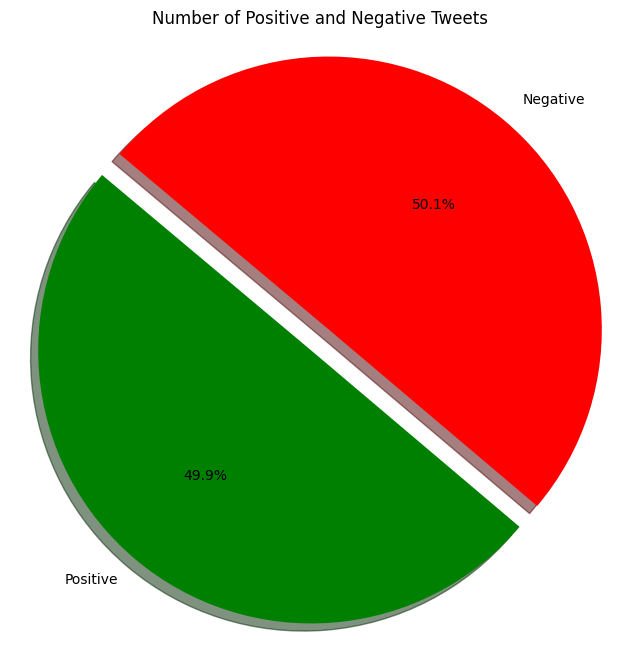

In [126]:
# Count the number of positive and negative tweets
pos_count = len(df_test_pos)
neg_count = len(df_test_neg)

# Labels and counts for the pie chart
labels = ['Positive', 'Negative']
sizes = [pos_count, neg_count]

colors = ['green', 'red']
explode = (0.1, 0) 

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.title('Number of Positive and Negative Tweets')
plt.axis('equal')
plt.show()


# Part 4: Build Model


In [127]:
# Assign labels: 1 for positive tweets and Assign labels:0 for negative tweets.
df_train_pos['label'] = 1
df_train_neg['label'] = 0
df_test_pos['label'] = 1
df_test_neg['label'] = 0

# Combine training and test sets
train_df = pd.concat([df_train_pos, df_train_neg]).reset_index(drop=True)
test_df = pd.concat([df_test_pos, df_test_neg]).reset_index(drop=True)

print("Training Data Sample:")
print(train_df.head())
print("\nTest Data Sample:")
print(test_df.head())

# define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', max_df=0.9, min_df=2)),
    ('clf', LinearSVC())
])

pipeline.fit(train_df["Arabic tweet"], train_df["label"])

y_pred = pipeline.predict(test_df["Arabic tweet"])

accuracy = accuracy_score(test_df["label"], y_pred)
precision = precision_score(test_df["label"], y_pred)
recall = recall_score(test_df["label"], y_pred)
f1 = f1_score(test_df["label"], y_pred)

print("Model Evaluation on Test Set:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nClassification Report:")
print(classification_report(test_df["label"], y_pred))

Training Data Sample:
  Sentiment Label                                       Arabic tweet  \
0             pos  نحن الذين يتحول كل ما نود أن نقوله إلى دعاء له...   
1             pos  وفي النهاية لن يبقى معك آحدإلا من رأى الجمال ف...   
2             pos                                    من الخير نفسه 💛   
3             pos  زلزلالملعبنصرنابيلعب كن عالي الهمه ولا ترضى بغ...   
4             pos  الشيء الوحيد الذي وصلوا فيه لعالمية هو المسيار...   

                                              tokens  label  
0  [نحن, الذين, يتحول, كل, ما, نود, أن, نقوله, إل...      1  
1  [وفي, النهاية, لن, يبقى, معك, آحدإلا, من, رأى,...      1  
2                                  [من, الخير, نفسه]      1  
3  [زلزلالملعبنصرنابيلعب, كن, عالي, الهمه, ولا, ت...      1  
4  [الشيء, الوحيد, الذي, وصلوا, فيه, لعالمية, هو,...      1  

Test Data Sample:
  Sentiment Label                                       Arabic tweet  \
0             pos  الهلالالاهلي فوز هلالي مهم الحمد له 💙 زوران كا...   
1         

### Sentiment Prediction Function

In [128]:
def predict_sentiment(text, model_pipeline):
    # Map the numeric predictions to their corresponding sentiment strings
    label_map = {1: "Positive", 0: "Negative"}
    
    # If a single string is passed, convert it to a list
    if isinstance(text, str):
        text = [text]
    
    # Make predictions using the trained model pipeline
    numeric_predictions = model_pipeline.predict(text)
    
    sentiment_predictions = [label_map[label] for label in numeric_predictions]
    
    return sentiment_predictions

# Example 
sample_tweet = "متوقعه يصير شي 💔"
predicted_label = predict_sentiment(sample_tweet, pipeline)
print("Predicted sentiment:", predicted_label)


Predicted sentiment: ['Negative']
